In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import pandas as pd
import numpy as np

#### load data

In [2]:
adata = sc.read_h5ad("./data/BoneMarrow/BoneMarrowA_BoneMarrowB.h5ad")
print(np.unique(adata.obs["Batch"]))

['BoneMarrowA' 'BoneMarrowB']


### Run CACNN

In [3]:
%cd scDIFF/CACNN

/home/daozhang/scDIFF/scDIFF/CACNN


In [4]:
!python train.py -i ../../data/BoneMarrow/BoneMarrowA_BoneMarrowB.h5ad \
            -g mm9 \
            -o ../../output/BoneMarrowA_BoneMarrowB \
            --tissue BoneMarrow \
            --bw_list H3k4me1_mm9.bigWig H3k4me3_mm9.bigWig H3k27ac_mm9.bigWig \
            --epifeature_dim 3 

INFO(20250527 20:47:09) [train.py:116]:
##time: Tue May 27 20:47:09 2025
##cwd: /home/daozhang/scDIFF/scDIFF/CACNN
##cmd: train.py -i ../../data/BoneMarrow/BoneMarrowA_BoneMarrowB.h5ad -g mm9 -o ../../output/BoneMarrowA_BoneMarrowB --tissue BoneMarrow --bw_list H3k4me1_mm9.bigWig H3k4me3_mm9.bigWig H3k27ac_mm9.bigWig --epifeature_dim 3
##args: Namespace(data='../../data/BoneMarrow/BoneMarrowA_BoneMarrowB.h5ad', z=64, g='mm9', lr=0.01, batch_size=128, num_workers=12, seq_len=1344, outdir='../../output/BoneMarrowA_BoneMarrowB', w=False, seed=2020, max_epoch=300, device=0, use_reg_cell=False, alpha=0.0, epifeature_dim=3, root_path='../../data/', tissue='BoneMarrow', bw_list=['H3k4me1_mm9.bigWig', 'H3k4me3_mm9.bigWig', 'H3k27ac_mm9.bigWig'])
Calculating AP: 100%|██████████████████████| 2000/2000 [00:03<00:00, 506.17it/s]
Epoch 100/300: 100%|█| 678/678 [00:28<00:00, 23.57it/s, loss/lr=0.0845/8.100e-03
Calculating AP: 100%|██████████████████████| 2000/2000 [00:03<00:00, 529.29it/s]
Epoch 101

### Run DIFFormer

In [5]:
%cd ../DIFFormer

/home/daozhang/scDIFF/scDIFF/DIFFormer


In [6]:
!python train.py --data_dir ../../output/BoneMarrowA_BoneMarrowB/CACNN_output.h5ad \
                --train_name_list BoneMarrowA --test_name BoneMarrowB \
                --save_path ../../output \
                --save_name BoneMarrowA_BoneMarrowB \
                --patience 50 \
                --dropout 0.0 

shape of concat train data:
	(4033, 64)
shape of concat test data:
	(4370, 64)
----------after remove unknown----------
shape of train data: (3944, 64)
shape of test data: (4189, 64)
----------after remove rare----------
shape of train data: (3936, 64)
shape of test data: (4179, 64)
----------after intersect----------
shape of train data: (3936, 64)
shape of test data: (4168, 64)
----------after SMOTE----------
shape of train data: (6449, 64)
shape of test data: (4168, 64)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression

### Visualization

In [7]:
%cd ../../

/home/daozhang/scDIFF


In [8]:
import matplotlib.pyplot as plt
import scanpy as sc
import matplotlib.font_manager as fm
import os
import pandas as pd

<Figure size 7680x5760 with 0 Axes>

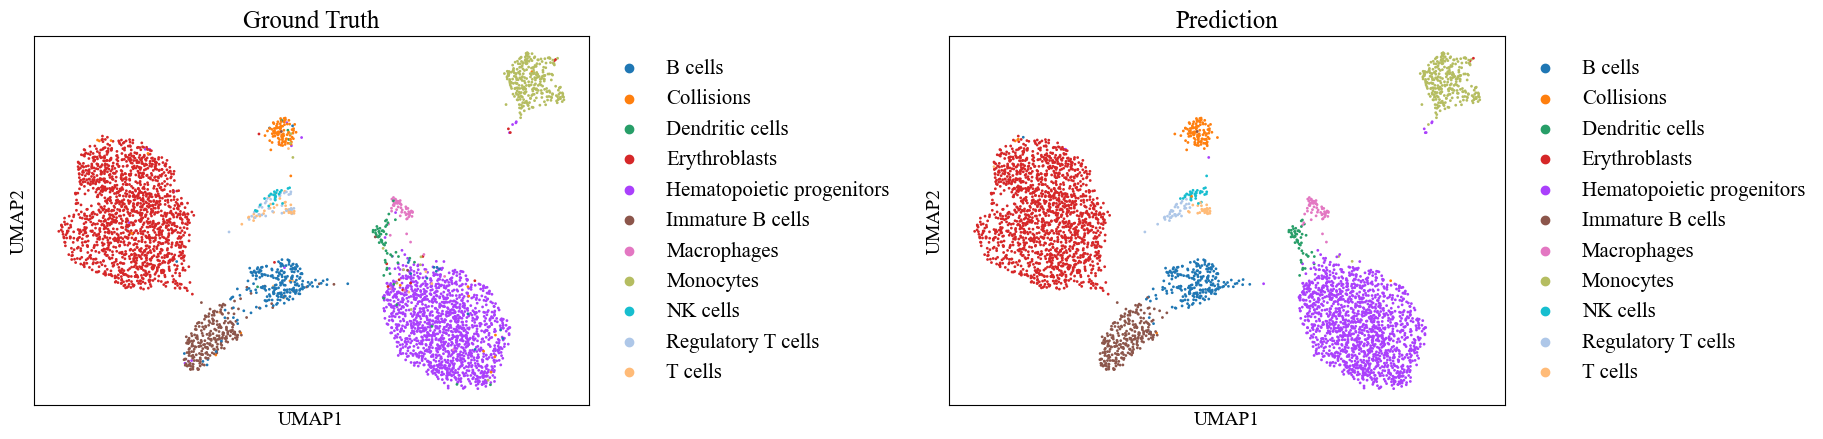

In [9]:
# Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  
plt.rcParams['axes.titlesize'] = 18  
plt.rcParams['axes.labelsize'] = 14  
plt.rcParams['xtick.labelsize'] = 12  
plt.rcParams['ytick.labelsize'] = 12  
plt.rcParams['legend.fontsize'] = 14  

adata = sc.read_h5ad("output/BoneMarrowA_BoneMarrowB/embedding.h5ad")
adata = adata[adata.obs["Batch"] == "BoneMarrowB"]

plt.figure(dpi=1200)

sc.pp.neighbors(adata, n_neighbors=25, use_rep='X', n_pcs=40)
sc.tl.umap(adata)

with plt.rc_context({'font.family': 'Times New Roman'}):
    sc.pl.umap(
        adata, 
        color=["CellType", "Pred"], 
        title=["Ground Truth", "Prediction"], 
        legend_fontsize=15,  
        legend_fontoutline=2,  
        frameon=True,  
        wspace=0.5,
        size=16,  
        # save="_BoneMarrowA_BoneMarrowB_GroundTruth_Pred.svg"
    )

#### Save Annotation and Ground Truth as a CSV file

In [10]:
# Save Annotation and Ground Truth as a CSV file
annotation = adata.obs["Pred"].values  # Predicted labels as Annotation
ground_truth = adata.obs['CellType'].values  # True labels as Ground_truth

# Create a DataFrame
df = pd.DataFrame({
    'true_label': ground_truth,
    'predicted_label': annotation
})

# Save to CSV
csv_path = os.path.join("output/BoneMarrowA_BoneMarrowB", "BoneMarrowA_BoneMarrowB_ref0_query1.csv")
df.to_csv(csv_path, index=False)

<Axes: >

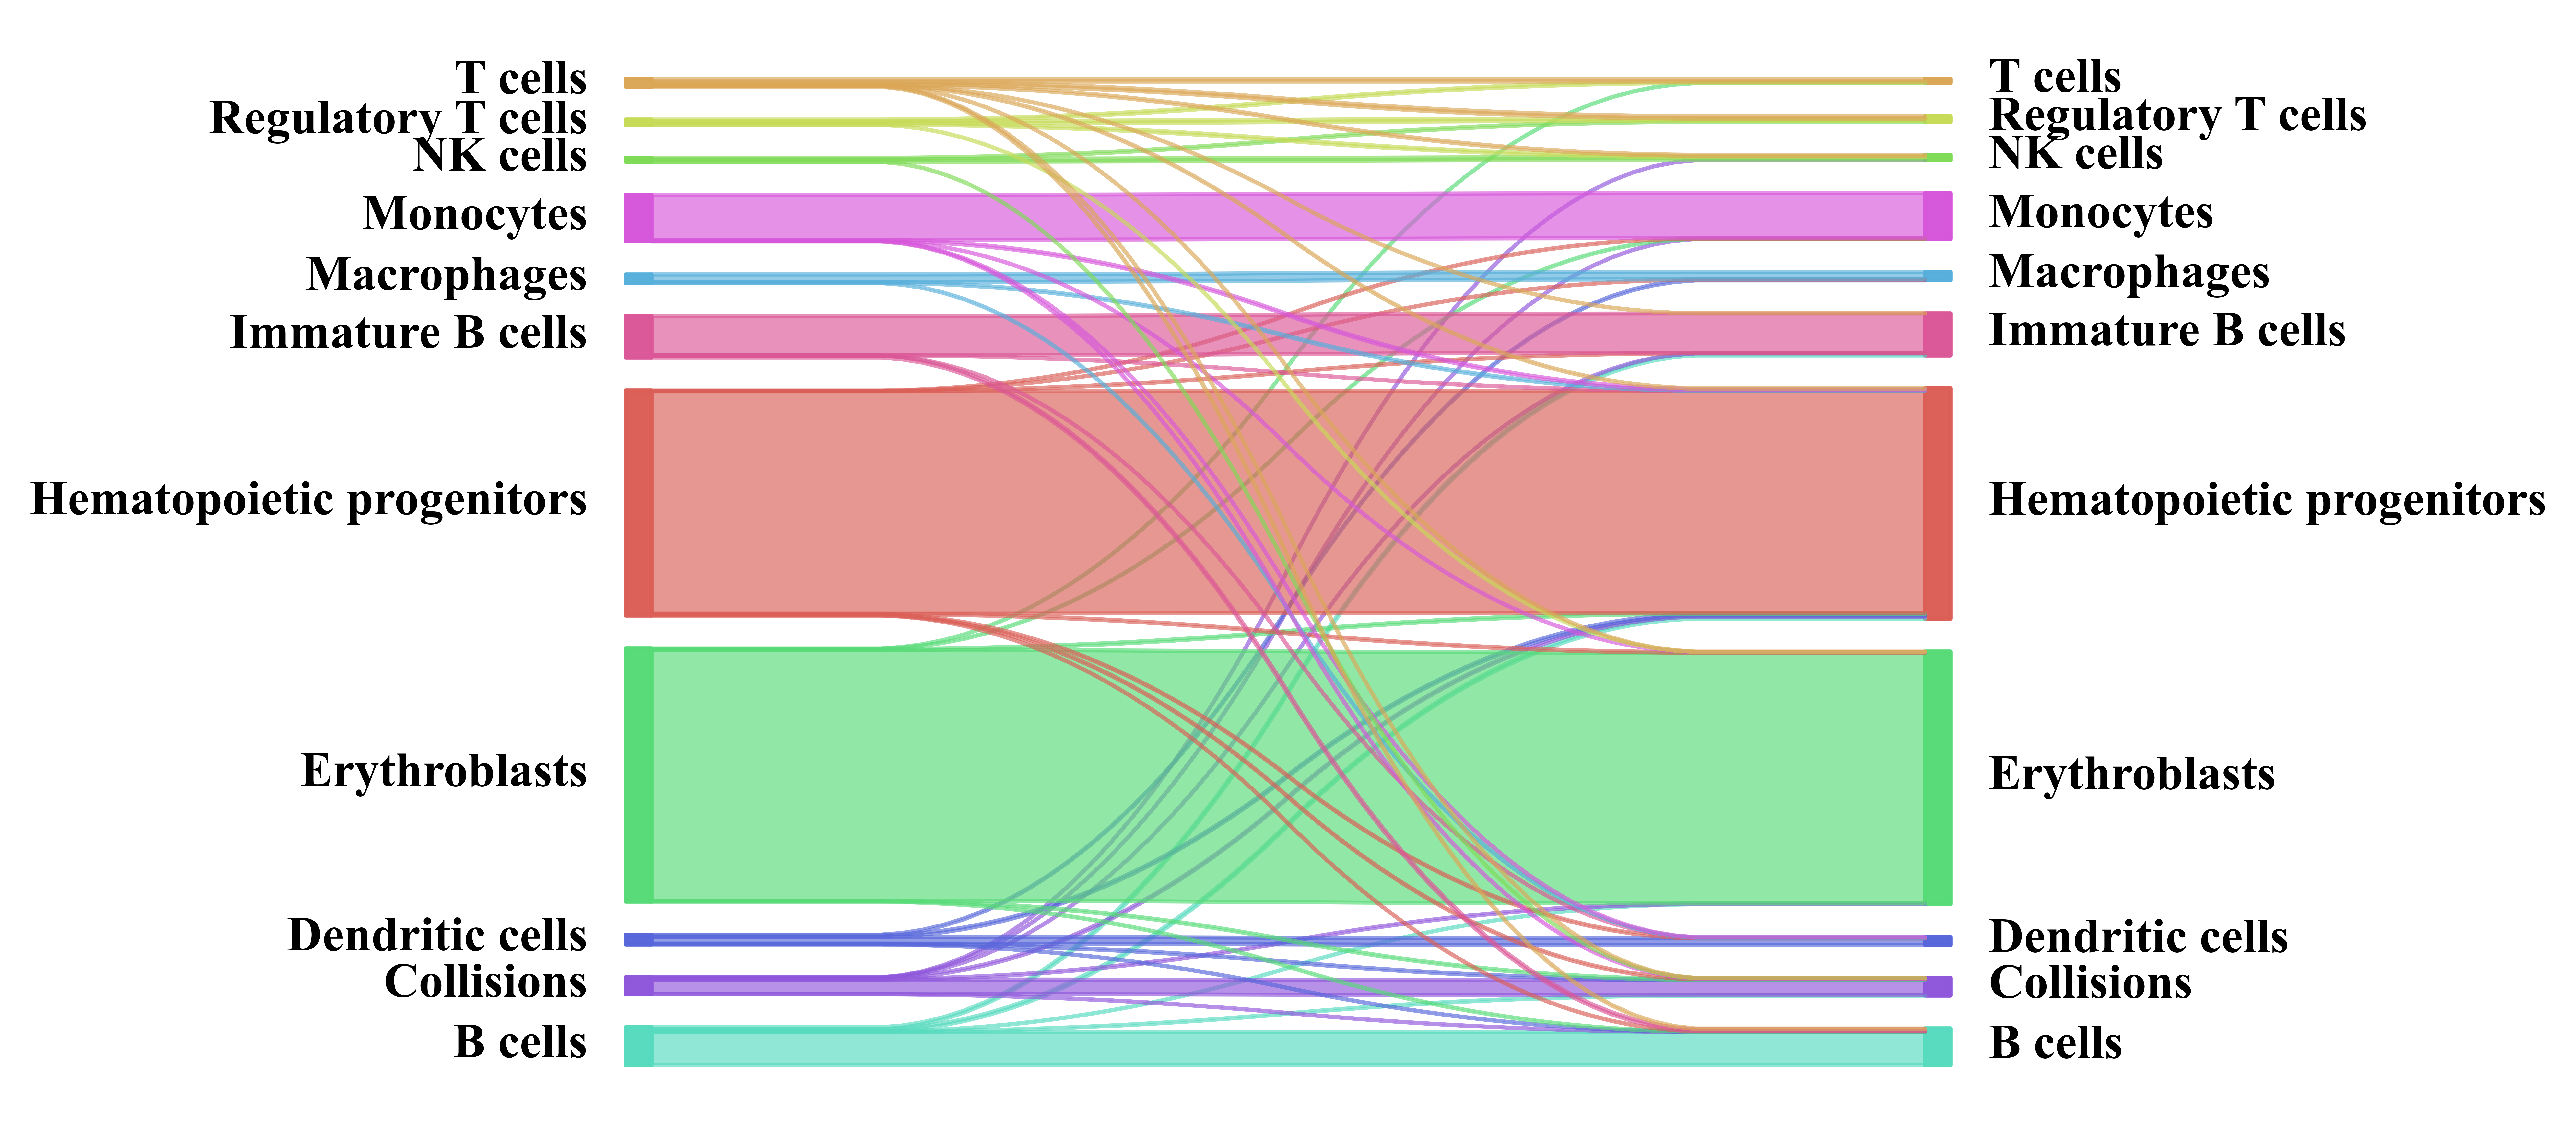

In [11]:
# from pySankey.sankey import sankey
import matplotlib.pyplot as plt
import numpy as np
from pysankey import sankey

plt.rcParams['font.family'] = 'Times New Roman'


pred_col = 'Pred'
true_col = 'CellType'

plt.rcParams['font.weight'] = "heavy"
plt.figure(dpi=1200)
sankey(
    adata.obs[true_col], adata.obs[pred_col], aspect=10,
    fontsize=12, leftLabels = list(np.unique(adata.obs[true_col])), rightLabels = list(np.unique(adata.obs[pred_col]))
    )
# plt.savefig("output/BoneMarrowA_BoneMarrowB_GroundTruth_Pred.svg", bbox_inches="tight")